# Setup

In [1]:
# import necessary libraries and files
import sys

sys.path.append('../src/data')
from make_dataset import *

sys.path.append('../src/models')
from lstm_model import *

## Data Preprocessing

In [2]:
filepath1 = '../data/raw/user1/'
df1, schema1, time_df1 = get_data(filepath1, read_from_notebook=True, out_schema=True)
all_time_df1 = save_time_measurement(time_df1, filepath1, saved=False)

apps1 = lstm_data(filepath1)

filepath2 = '../data/raw/user2/'
apps2 = lstm_data(filepath2)

## Bidirectional LSTM with Lookback Feature Engineering

In [ ]:
model, out_df, X_train, X_test, y_train, y_test = bi_lstm(apps1, app_name='chrome.exe', at_most=1)

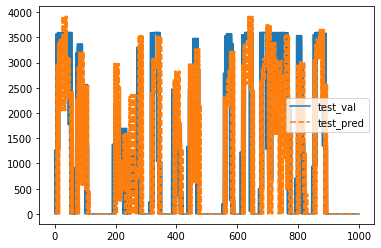

In [29]:
out_df = predict(model, X_test, y_test, time_step=5, n_features=1)

In [5]:
test_acc(out_df, at_most = 1) # accuracy if predictions are within 1 sec

RMSE = 1309.712663951226
ACC = 76.85525349008083


In [6]:
test_acc(out_df, at_most = 180) # accuracy if predictions are within 3 mins

RMSE = 1309.712663951226
ACC = 78.6921381337252


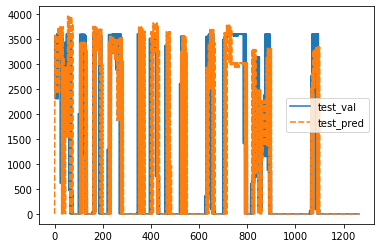

In [220]:
out_df = predict(model, X_test, y_test, time_step=5, n_features=1)

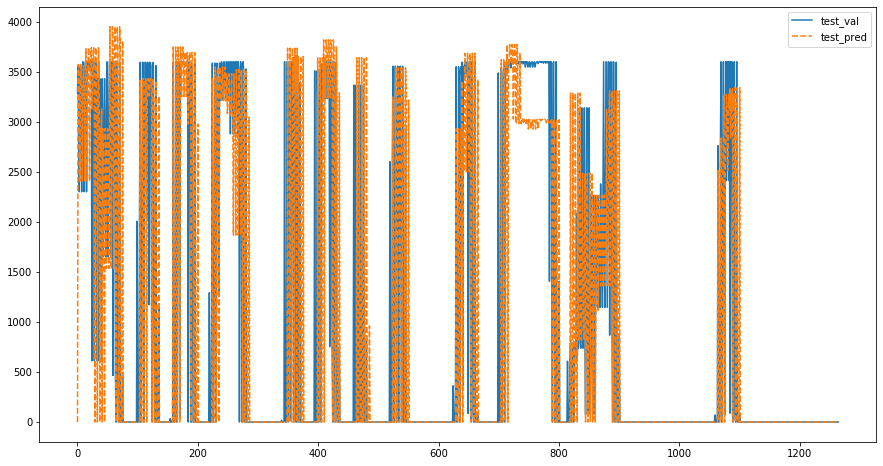

In [224]:
plt.figure(figsize=(15,8))
sns.lineplot(out_df[['test_val', 'test_pred']])

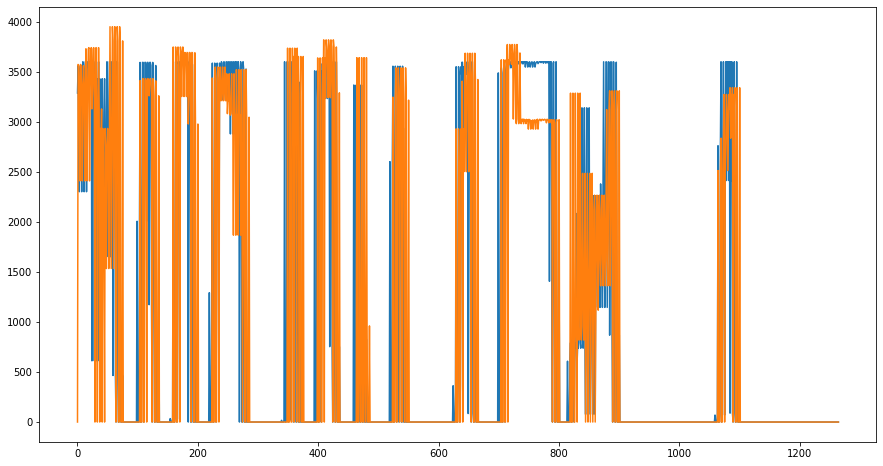

In [233]:
plt.figure(figsize=(15,8))
plt.plot(out_df['test_val'])
plt.plot(out_df['test_pred'])

In [225]:
test_acc(out_df, at_most = 1)

RMSE = 938.3587213544401
ACC = 60.47430830039525


In [230]:
test_acc(out_df, at_most = 15)

RMSE = 938.3587213544401
ACC = 61.42292490118577


In [223]:
test_acc(out_df, at_most = 180)

RMSE = 938.3587213544401
ACC = 70.51383399209486


In [229]:
test_acc(out_df, at_most = 300)

RMSE = 938.3587213544401
ACC = 73.67588932806323


RMSE = 1367.1994735974401
ACC = 76.85525349008083


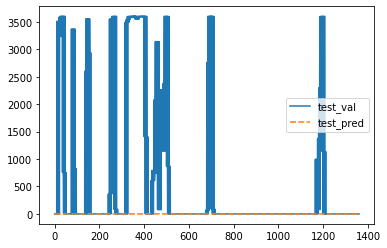

In [7]:
model, out_df, X_train, X_test, y_train, y_test = bi_lstm(apps1, app_name='chrome.exe', at_most=1)